# Model Building: 
I used a multi-input neural network that had three inputs (session history, order history, and month of order) and 1 output (probability 1 or products would be purchased in each category.) I considered using a recommender system such as collaborative filtering, but felt that the limited number of outputs and the fact that users can be repeat buyers made me elect to make this a classification problem.

    Performance Evaluation - I used Mean AUC of the ROC Curve and Mean Average Precision to evaluate predictive performance because they are independent of any chosen probability cutoff.
        Mean AUC of ROC Curve - This metric tells me whether or not the model is performing better than random (0.5) on average for each of the 6 product classes.
        Mean Average Precision - This metric shows the average average precision across all levels of recall for all classes. The closer it is to 1 the better the performance. (This metric is very sensitive to the baseline proportion between the classes)



In [1]:
import tensorflow_io as tfio

In [2]:
import datetime

In [3]:
import matplotlib.pyplot as plt
import h5py
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from performance_evaluation import plot_training_history, evaluate_model_performance

from tensorflow.python.client import device_lib

In [4]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(
    physical_devices[0], enable=True
)

# Read in Data

In [5]:
train_data = h5py.File('data/online_and_order/order_history_train.h5', 'r')

In [6]:
train_X_orders = np.array(train_data.get('train_X_orders'))
train_X_order_month = np.array(train_data.get('train_X_order_month'))
train_X_sessions = np.array(train_data.get('train_X_sessions'))
train_Y_order = np.array(train_data.get('train_Y_order'))

In [7]:
train_data.close()

In [8]:
test_data = h5py.File('data/online_and_order/order_history_test.h5', 'r')

In [9]:
test_X_orders = np.array(test_data.get('test_X_orders'))
test_X_order_month = np.array(test_data.get('test_X_order_month'))
test_X_sessions = np.array(test_data.get('test_X_sessions'))
test_Y_order = np.array(test_data.get('test_Y_order'))

In [10]:
test_data.close()

#### Normalize for Faster Training

In [11]:
def zero_to_ones(value):
    if value ==0:
        return 1
    else:
        return value

range_for_x_cols = np.amax(train_X_orders, axis=0) - np.amin(train_X_orders, axis=0)
range_for_x_cols[range_for_x_cols == 0] = 1

In [12]:
norm_train_x = train_X_orders/range_for_x_cols
norm_test_x = test_X_orders/range_for_x_cols

# Setup Model Architecture

In [13]:
order_history = keras.Input(
    shape=(train_X_orders.shape[1], train_X_orders.shape[2],), 
    name='Order_History'
)

In [14]:
order_month = keras.Input(
    shape=(train_X_order_month.shape[1],), 
    name='Order_Month'
)

In [15]:
session_history = keras.Input(
    shape=(test_X_sessions.shape[1], test_X_sessions.shape[2],), 
    name='Session_History'
)

In [16]:
dropout = .6

In [17]:
i=1

#### Set Order History Pipeline

In [18]:
ord_hist_x = layers.GRU(
    100, 
    name=f'ord_hist_GRU1',
    activation = 'tanh',
    recurrent_activation = 'sigmoid',
    recurrent_dropout = 0,
    dropout = dropout, 
    unroll = False,
    use_bias = True,
    return_sequences=True
)(order_history)

In [19]:
ord_hist_x = layers.GRU(
    100, 
    name=f'ord_hist_GRU2',
    activation = 'tanh',
    recurrent_activation = 'sigmoid',
    recurrent_dropout = 0,
    dropout = dropout,
    unroll = False,
    use_bias = True    
)(ord_hist_x)

In [20]:
ord_hist_x = keras.layers.Flatten()(ord_hist_x)

#### Session History

In [21]:
sess_hist_x = layers.GRU(
    100, 
    name=f'sess_hist_GRU1',
    activation = 'tanh',
    recurrent_activation = 'sigmoid',
    recurrent_dropout = 0,
    dropout = dropout, 
    unroll = False,
    use_bias = True,
    return_sequences=True
)(session_history)

In [22]:
sess_hist_x = layers.GRU(
    100, 
    name=f'sess_hist_GRU2',
    activation = 'tanh',
    recurrent_activation = 'sigmoid',
    recurrent_dropout = 0,
    dropout = dropout,
    unroll = False,
    use_bias = True    
)(sess_hist_x)

In [23]:
sess_hist_x = keras.layers.Flatten()(sess_hist_x)

In [24]:
concat_x = keras.layers.Concatenate(axis=1)([ord_hist_x, order_month, sess_hist_x])

In [25]:
x = layers.BatchNormalization()(concat_x)
x = layers.Dense(100, activation='elu')(x)
x = layers.Dropout(dropout)(x)

In [26]:
# Adding another concatenation of order month to ensure the signal isn't lost due to dropout
x = keras.layers.Concatenate(axis=1)([x, order_month])

In [27]:
x = layers.BatchNormalization()(x)
x = layers.Dense(100, activation='elu')(x)
x = layers.Dropout(dropout)(x)

In [28]:
x = layers.BatchNormalization()(x)
x = layers.Dense(100, activation='elu')(x)
x = layers.Dropout(dropout)(x)

In [29]:
x = layers.BatchNormalization()(x)
x = layers.Dense(100, activation='elu')(x)
x = layers.Dropout(dropout)(x)

In [30]:
outputs = layers.Dense(6, activation='sigmoid')(x)

In [31]:
model = keras.Model(
    inputs=[order_history, order_month,session_history], 
    outputs=outputs, name="3_Channel_GRU_NN"
)

In [32]:
model.summary()

Model: "3_Channel_GRU_NN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Order_History (InputLayer)      [(None, 14, 253)]    0                                            
__________________________________________________________________________________________________
Session_History (InputLayer)    [(None, 53, 24)]     0                                            
__________________________________________________________________________________________________
ord_hist_GRU1 (GRU)             (None, 14, 100)      106500      Order_History[0][0]              
__________________________________________________________________________________________________
sess_hist_GRU1 (GRU)            (None, 53, 100)      37800       Session_History[0][0]            
___________________________________________________________________________________

In [33]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=["accuracy"],
)

In [34]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

In [35]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


In [36]:
# Remove Existing Logs in TensorBoard
!rm -r /home/ben/gitrepos/shfly/logs

In [37]:
history = model.fit(
    [train_X_orders, train_X_order_month, train_X_sessions],
    train_Y_order, batch_size=5000, epochs=800, validation_split=0.2,
    callbacks=[tensorboard_callback]
)

Epoch 1/800
 1/14 [=>............................] - ETA: 0s - loss: 2.3452 - accuracy: 0.1710WARNING:tensorflow:From /home/ben/anaconda3/lib/python3.8/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
14/14 [==============================] - 4s 287ms/step - loss: 2.2712 - accuracy: 0.2131 - val_loss: 1.8577 - val_accuracy: 0.1448
Epoch 2/800
14/14 [==============================] - 3s 216ms/step - loss: 2.1370 - accuracy: 0.2972 - val_loss: 1.8320 - val_accuracy: 0.3088
Epoch 3/800
14/14 [==============================] - 3s 216ms/step - loss: 2.0641 - accuracy: 0.3455 - val_loss: 1.8242 - val_accuracy: 0.2820
Epoch 4/800
14/14 [==============================] - 3s 217ms/step - loss: 2.0373 - accuracy: 0.3663 - val_loss: 1.8184 - val_accuracy: 0.2574
Epoch 5/800
14/14 [==============================] - 3s 217

Epoch 112/800
14/14 [==============================] - 3s 209ms/step - loss: 1.8644 - accuracy: 0.4325 - val_loss: 1.7622 - val_accuracy: 0.3157
Epoch 113/800
14/14 [==============================] - 3s 210ms/step - loss: 1.8627 - accuracy: 0.4327 - val_loss: 1.7687 - val_accuracy: 0.3195
Epoch 114/800
14/14 [==============================] - 3s 211ms/step - loss: 1.8636 - accuracy: 0.4323 - val_loss: 1.8005 - val_accuracy: 0.3017
Epoch 115/800
14/14 [==============================] - 3s 210ms/step - loss: 1.8595 - accuracy: 0.4369 - val_loss: 1.8024 - val_accuracy: 0.3127
Epoch 116/800
14/14 [==============================] - 3s 210ms/step - loss: 1.8598 - accuracy: 0.4359 - val_loss: 1.7924 - val_accuracy: 0.3080
Epoch 117/800
14/14 [==============================] - 3s 210ms/step - loss: 1.8602 - accuracy: 0.4359 - val_loss: 1.7863 - val_accuracy: 0.3080
Epoch 118/800
14/14 [==============================] - 3s 211ms/step - loss: 1.8604 - accuracy: 0.4353 - val_loss: 1.7976 - val_ac

14/14 [==============================] - 3s 210ms/step - loss: 1.8349 - accuracy: 0.4447 - val_loss: 1.7360 - val_accuracy: 0.3275
Epoch 225/800
14/14 [==============================] - 3s 210ms/step - loss: 1.8363 - accuracy: 0.4423 - val_loss: 1.7136 - val_accuracy: 0.3508
Epoch 226/800
14/14 [==============================] - 3s 209ms/step - loss: 1.8371 - accuracy: 0.4453 - val_loss: 1.7799 - val_accuracy: 0.3275
Epoch 227/800
14/14 [==============================] - 3s 209ms/step - loss: 1.8352 - accuracy: 0.4462 - val_loss: 1.7338 - val_accuracy: 0.3290
Epoch 228/800
14/14 [==============================] - 3s 209ms/step - loss: 1.8364 - accuracy: 0.4435 - val_loss: 1.7413 - val_accuracy: 0.3180
Epoch 229/800
14/14 [==============================] - 3s 209ms/step - loss: 1.8346 - accuracy: 0.4434 - val_loss: 1.7235 - val_accuracy: 0.3212
Epoch 230/800
14/14 [==============================] - 3s 210ms/step - loss: 1.8368 - accuracy: 0.4434 - val_loss: 1.7475 - val_accuracy: 0.3102

14/14 [==============================] - 3s 210ms/step - loss: 1.8216 - accuracy: 0.4479 - val_loss: 1.7369 - val_accuracy: 0.3380
Epoch 337/800
14/14 [==============================] - 3s 211ms/step - loss: 1.8203 - accuracy: 0.4494 - val_loss: 1.7683 - val_accuracy: 0.3228
Epoch 338/800
14/14 [==============================] - 3s 212ms/step - loss: 1.8200 - accuracy: 0.4496 - val_loss: 1.7432 - val_accuracy: 0.3320
Epoch 339/800
14/14 [==============================] - 3s 213ms/step - loss: 1.8199 - accuracy: 0.4482 - val_loss: 1.7385 - val_accuracy: 0.3230
Epoch 340/800
14/14 [==============================] - 3s 210ms/step - loss: 1.8192 - accuracy: 0.4511 - val_loss: 1.7188 - val_accuracy: 0.3439
Epoch 341/800
14/14 [==============================] - 3s 210ms/step - loss: 1.8198 - accuracy: 0.4478 - val_loss: 1.7466 - val_accuracy: 0.3236
Epoch 342/800
14/14 [==============================] - 3s 209ms/step - loss: 1.8202 - accuracy: 0.4497 - val_loss: 1.7680 - val_accuracy: 0.3155

14/14 [==============================] - 3s 212ms/step - loss: 1.8128 - accuracy: 0.4491 - val_loss: 1.7687 - val_accuracy: 0.3159
Epoch 449/800
14/14 [==============================] - 3s 211ms/step - loss: 1.8120 - accuracy: 0.4503 - val_loss: 1.7168 - val_accuracy: 0.3290
Epoch 450/800
14/14 [==============================] - 3s 214ms/step - loss: 1.8133 - accuracy: 0.4527 - val_loss: 1.7245 - val_accuracy: 0.3246
Epoch 451/800
14/14 [==============================] - 3s 213ms/step - loss: 1.8105 - accuracy: 0.4509 - val_loss: 1.7365 - val_accuracy: 0.3293
Epoch 452/800
14/14 [==============================] - 3s 216ms/step - loss: 1.8101 - accuracy: 0.4547 - val_loss: 1.7501 - val_accuracy: 0.3293
Epoch 453/800
14/14 [==============================] - 3s 210ms/step - loss: 1.8108 - accuracy: 0.4529 - val_loss: 1.7585 - val_accuracy: 0.3186
Epoch 454/800
14/14 [==============================] - 3s 212ms/step - loss: 1.8118 - accuracy: 0.4523 - val_loss: 1.7111 - val_accuracy: 0.3466

14/14 [==============================] - 3s 211ms/step - loss: 1.8023 - accuracy: 0.4520 - val_loss: 1.7722 - val_accuracy: 0.3132
Epoch 561/800
14/14 [==============================] - 3s 211ms/step - loss: 1.8054 - accuracy: 0.4546 - val_loss: 1.7599 - val_accuracy: 0.3240
Epoch 562/800
14/14 [==============================] - 3s 211ms/step - loss: 1.8034 - accuracy: 0.4530 - val_loss: 1.7435 - val_accuracy: 0.3300
Epoch 563/800
14/14 [==============================] - 3s 211ms/step - loss: 1.8056 - accuracy: 0.4518 - val_loss: 1.7177 - val_accuracy: 0.3365
Epoch 564/800
14/14 [==============================] - 3s 213ms/step - loss: 1.8045 - accuracy: 0.4536 - val_loss: 1.7432 - val_accuracy: 0.3269
Epoch 565/800
14/14 [==============================] - 3s 210ms/step - loss: 1.8023 - accuracy: 0.4549 - val_loss: 1.7060 - val_accuracy: 0.3413
Epoch 566/800
14/14 [==============================] - 3s 213ms/step - loss: 1.8035 - accuracy: 0.4537 - val_loss: 1.7746 - val_accuracy: 0.3104

14/14 [==============================] - 3s 209ms/step - loss: 1.7993 - accuracy: 0.4547 - val_loss: 1.7593 - val_accuracy: 0.3227
Epoch 673/800
14/14 [==============================] - 3s 208ms/step - loss: 1.7969 - accuracy: 0.4574 - val_loss: 1.7488 - val_accuracy: 0.3265
Epoch 674/800
14/14 [==============================] - 3s 210ms/step - loss: 1.7975 - accuracy: 0.4564 - val_loss: 1.7665 - val_accuracy: 0.3186
Epoch 675/800
14/14 [==============================] - 3s 210ms/step - loss: 1.7985 - accuracy: 0.4538 - val_loss: 1.7515 - val_accuracy: 0.3185
Epoch 676/800
14/14 [==============================] - 3s 210ms/step - loss: 1.7990 - accuracy: 0.4547 - val_loss: 1.7298 - val_accuracy: 0.3360
Epoch 677/800
14/14 [==============================] - 3s 214ms/step - loss: 1.7983 - accuracy: 0.4570 - val_loss: 1.7453 - val_accuracy: 0.3224
Epoch 678/800
14/14 [==============================] - 3s 209ms/step - loss: 1.7955 - accuracy: 0.4570 - val_loss: 1.7306 - val_accuracy: 0.3282

14/14 [==============================] - 4s 253ms/step - loss: 1.7921 - accuracy: 0.4585 - val_loss: 1.7007 - val_accuracy: 0.3520
Epoch 785/800
14/14 [==============================] - 4s 253ms/step - loss: 1.7919 - accuracy: 0.4594 - val_loss: 1.7194 - val_accuracy: 0.3363
Epoch 786/800
14/14 [==============================] - 4s 252ms/step - loss: 1.7924 - accuracy: 0.4585 - val_loss: 1.6983 - val_accuracy: 0.3500
Epoch 787/800
14/14 [==============================] - 4s 251ms/step - loss: 1.7936 - accuracy: 0.4569 - val_loss: 1.7486 - val_accuracy: 0.3247
Epoch 788/800
14/14 [==============================] - 3s 250ms/step - loss: 1.7903 - accuracy: 0.4608 - val_loss: 1.7709 - val_accuracy: 0.3235
Epoch 789/800
14/14 [==============================] - 3s 246ms/step - loss: 1.7896 - accuracy: 0.4604 - val_loss: 1.7714 - val_accuracy: 0.3167
Epoch 790/800
14/14 [==============================] - 3s 233ms/step - loss: 1.7905 - accuracy: 0.4577 - val_loss: 1.7560 - val_accuracy: 0.3219

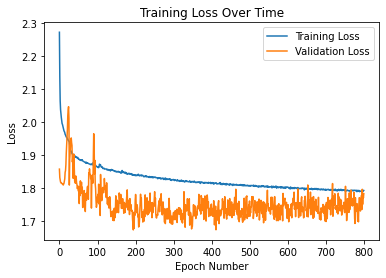

In [38]:
plot_training_history(history)

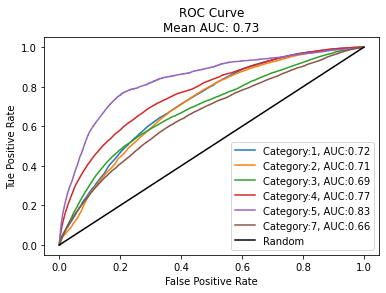

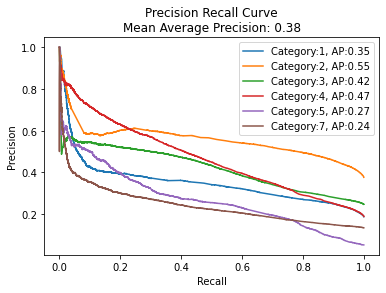

In [39]:
pred_y = model.predict([train_X_orders, train_X_order_month, train_X_sessions])
evaluate_model_performance(pred_y, train_Y_order)

#### Test Performance

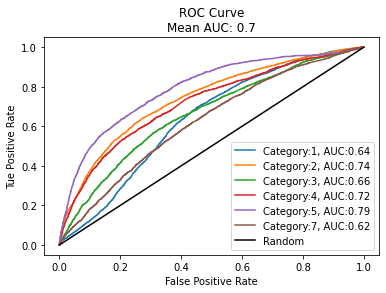

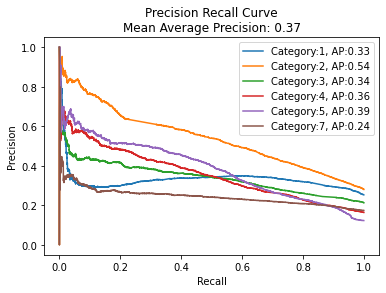

In [40]:
pred_y = model.predict([test_X_orders, test_X_order_month, test_X_sessions])
evaluate_model_performance(pred_y, test_Y_order)